In [ ]:
import os, sys
dir1 = os.path.abspath('..\..')
sys.path.append(dir1+ "\\")

import MetaTrader5 as mt
from datetime import datetime as dt

# custom
from my_jupyter.user import User
from my_jupyter.strategy_manager import StrategyManager
from my_jupyter.operation import Operation
from my_jupyter.strategies.min_max_strategy import MinMaxStrategy
from my_jupyter.market_data_repository import MarketDataRepository
from my_jupyter.filters.moving_average import MovingAverageFilter
from my_jupyter.filters.consequent_limits_counter import ConsequentLimitsCounterFilter
from my_jupyter.filters.directioned_bars_filter import DirectionedBarsFilter

# from Mbox import Mbox
# from boleta_1 import gerar_boleta
# from gerenciamento import Gerenciamento

## GUI's
from daemon_tools import DaemonThreadMini


In [ ]:


filters = [DirectionedBarsFilter(candles=5), MovingAverageFilter(), MovingAverageFilter(period=200)]
strategies = [MinMaxStrategy(filters=filters)]
operations = [Operation("WINV23", 1, mt.TIMEFRAME_M1, can_buy=True, can_sell=True)]
user = User(strategies=strategies, operations=operations, trading_time_start=dt(2023,10,5,9,5,0))
market_data_repository = MarketDataRepository()
strategy = StrategyManager(market_data_repository, user)

# PARAMETROS MAIN
kwargs = {
    "strategy": strategy,
}


def main(**kwargs):
    _shift = 0
    strategy: StrategyManager = kwargs["strategy"]
    strategy.run_strategies()
    # print(f"{dt.now().strftime('%d/%m/%Y, %H:%M:%S')} >>> D-{_shift}")
def exec_daemon(**kwargs):
    main(**kwargs)
    # alarme.ring_alarme()

In [ ]:
# gerenciamento = Gerenciamento(mt, timeframe, timeframes_dict)

try:
    main(**kwargs)
except Exception as e:
    print(e.with_traceback(__tb=None))
    # Mbox.Alerta("ERRO", "busca de sinais com erro")


In [ ]:
# from my_jupyter.daemons.daemon_tools import DaemonThreadMini


# thread_exec = DaemonThreadMini(exec_daemon, seconds=0, mseconds=800, **kwargs)
# thread_exec.start()

In [1]:
import os, sys

dir1 = os.path.abspath("..\..")
if dir1 not in sys.path:
    sys.path.append(dir1 + "\\")


from my_jupyter.indicator.prices_direction_ml import PricesDirectionML

bars_trend_ml = PricesDirectionML(quantity_of_bars_in_thousands=4)
bars_trend_ml.set_machine_learning_model(from_stock_market_data="WIN$")

c:\repo\python\financial-api\my_jupyter\modules\prices_direction_ml_backtest.py:29: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(


before filter 606 579 1801
after filter 578 578 578
Epoch 1/10
44/44 [==============================] - 1s 12ms/step - loss: 1.0235 - accuracy: 0.3896 - val_loss: 0.9256 - val_accuracy: 0.5321
Epoch 2/10
44/44 [==============================] - 0s 4ms/step - loss: 0.7230 - accuracy: 0.7450 - val_loss: 0.4786 - val_accuracy: 0.9487
Epoch 3/10
44/44 [==============================] - 0s 4ms/step - loss: 0.3376 - accuracy: 0.9929 - val_loss: 0.2084 - val_accuracy: 1.0000
Epoch 4/10
44/44 [==============================] - 0s 5ms/step - loss: 0.1467 - accuracy: 1.0000 - val_loss: 0.0993 - val_accuracy: 1.0000
Epoch 5/10
44/44 [==============================] - 0s 5ms/step - loss: 0.0744 - accuracy: 1.0000 - val_loss: 0.0551 - val_accuracy: 1.0000
Epoch 6/10
44/44 [==============================] - 0s 5ms/step - loss: 0.0449 - accuracy: 1.0000 - val_loss: 0.0388 - val_accuracy: 1.0000
Epoch 7/10
44/44 [==============================] - 0s 5ms/step - loss: 0.0325 - accuracy: 1.0000 - val_los

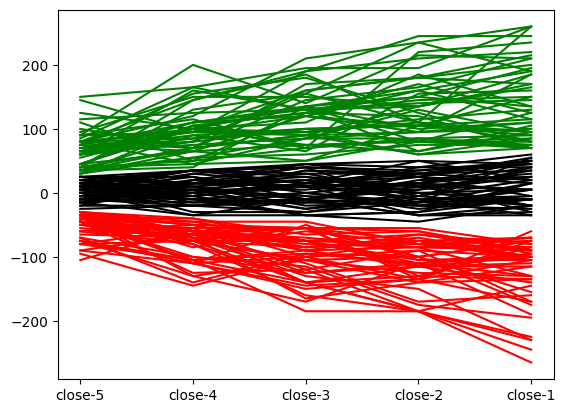

In [2]:
import matplotlib.pyplot as plt
df = bars_trend_ml.df
s = df[df["act"]==0][:50].drop("act",axis=1).T
w = df[df["act"]==1][:50].drop("act",axis=1).T
b = df[df["act"]==2][:50].drop("act",axis=1).T
plt.plot(s,"r")
plt.plot(w,"k")
plt.plot(b,"g")
plt.show()

2/2 - 0s - 80ms/epoch - 40ms/step
{'out': [100.0, 87.0, 0.0], 'in': 1   -60.0
2   -70.0
3   -70.0
4   -75.0
5   -45.0
dtype: float64, 'time': datetime.datetime(2023, 10, 17, 17, 47), 'price': array([115860., 115800., 115790., 115790., 115785., 115815.])}
{'out': [100.0, 87.0, 0.0], 'in': 1   -60.0
2   -70.0
3   -70.0
4   -75.0
5   -45.0
dtype: float64, 'time': datetime.datetime(2023, 10, 17, 17, 47), 'price': array([115860., 115800., 115790., 115790., 115785., 115815.])}
{'out': [100.0, 84.0, 0.0], 'in': 1    -50.0
2   -100.0
3    -70.0
4    -70.0
5    -65.0
dtype: float64, 'time': datetime.datetime(2023, 10, 17, 17, 38), 'price': array([115890., 115840., 115790., 115820., 115820., 115825.])}
{'out': [100.0, 84.0, 0.0], 'in': 1    -50.0
2   -100.0
3    -70.0
4    -70.0
5    -65.0
dtype: float64, 'time': datetime.datetime(2023, 10, 17, 17, 38), 'price': array([115890., 115840., 115790., 115820., 115820., 115825.])}
{'out': [100.0, 89.0, 0.0], 'in': 1    -10.0
2    -60.0
3   -110.0
4    

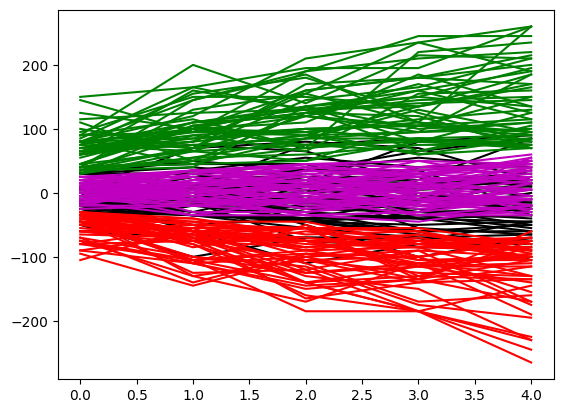

In [3]:
from my_jupyter.market_data_repository import MarketDataRepository
from datetime import datetime as dt, timedelta as td
import numpy as np
import pandas as pd

mt_rep = MarketDataRepository()

ohlc = mt_rep.mt.copy_rates_from_pos("WIN$", mt_rep.mt.TIMEFRAME_M1, 0, 60)
ohlc_0_based = ohlc[::-1]
# print([ dt.fromtimestamp(i[0]) for i in ohlc_0_based])
# bars_trend_ml.output(ohlc_0_based[1:])


to_timestamp = lambda x: dt.fromtimestamp(x) + td(hours=3)
input_da_ML = 6
ohlc_transform = [
    (
        ohlc_0_based[i : i + input_da_ML][::-1]["close"],
        to_timestamp(ohlc_0_based[i]["time"]),
    )
    for i in range(0, len(ohlc_0_based) - input_da_ML)
]
# ohlc_transform = [ i - min(i) for i in ohlc_transform ]
ohlc_transform = [
    (
        pd.Series(ohlc_transform[i][0]).diff().cumsum().dropna(),
        ohlc_transform[i][1],
        ohlc_transform[i][0],
    )
    for i in range(len(ohlc_transform))
]

results = []
df = pd.DataFrame()
inputs = []
for i in range(0, len(ohlc_transform)):
    inputs.append(ohlc_transform[i][0])
res = bars_trend_ml.output(inputs)
for i in range(len(res)):
    r = np.round(res[i] * 100)
    results.append(
        {
            "out": list(r),
            "in": ohlc_transform[i][0],
            "time": ohlc_transform[i][1],
            "price": ohlc_transform[i][2],
        }
    )

analyze = 0
res = sorted(results, key=lambda x: -x["out"][analyze])
# print(">>>>>>>>>>", *res,sep="\n")
for i in range(len(res)):
    # if res[i][0][2]> 50:
    if res[i]["out"][analyze] == max(res[i]["out"][0], res[i]["out"][2]):
        print(res[i])
        # pd.Series(res[i]["in"]).plot()
        pass
    print(res[i])
    plt.plot(res[i]["in"].values,"k")
import matplotlib.pyplot as plt
df = bars_trend_ml.df
s = df[df["act"]==0][:50].drop("act",axis=1).T
w = df[df["act"]==1][:50].drop("act",axis=1).T
b = df[df["act"]==2][:50].drop("act",axis=1).T
plt.plot(s.values,"r")
plt.plot(w.values,"m")
plt.plot(b.values,"g")
plt.show()

In [6]:
ohlc_transform

[(0     NaN
  1   -10.0
  2    20.0
  3    40.0
  4    35.0
  dtype: float64,
  datetime.datetime(2023, 10, 17, 14, 8),
  array([115905., 115895., 115925., 115945., 115940.])),
 (0     NaN
  1    30.0
  2    50.0
  3    45.0
  4    60.0
  dtype: float64,
  datetime.datetime(2023, 10, 17, 14, 7),
  array([115895., 115925., 115945., 115940., 115955.])),
 (0     NaN
  1    20.0
  2    15.0
  3    30.0
  4     0.0
  dtype: float64,
  datetime.datetime(2023, 10, 17, 14, 6),
  array([115925., 115945., 115940., 115955., 115925.])),
 (0     NaN
  1    -5.0
  2    10.0
  3   -20.0
  4   -15.0
  dtype: float64,
  datetime.datetime(2023, 10, 17, 14, 5),
  array([115945., 115940., 115955., 115925., 115930.])),
 (0     NaN
  1    15.0
  2   -15.0
  3   -10.0
  4    20.0
  dtype: float64,
  datetime.datetime(2023, 10, 17, 14, 4),
  array([115940., 115955., 115925., 115930., 115960.])),
 (0     NaN
  1   -30.0
  2   -25.0
  3     5.0
  4    10.0
  dtype: float64,
  datetime.datetime(2023, 10, 17, 14,

In [20]:
analyze = 0
res = sorted(results, key=lambda x: -x["out"][analyze])
for i in range(len(res)):
    # if res[i][0][2]> 50:
    if res[i]["out"][analyze] == max(res[i]["out"]):
        print(res[i])
        # pd.Series(res[i]["in"]).plot()


In [21]:
res

[{'out': [54.0, 63.0, 43.0],
  'in': array([116005., 115990., 115915., 115955.]),
  'time': datetime.datetime(2023, 10, 17, 13, 50)}]